In [1]:
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data
from torch_geometric.loader import *
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

class SageConvLayer(nn.Module):
    def __init__(self, in_dim, out_dim, aggr):
        super(SageConvLayer, self).__init__()
        self.sage_conv = SAGEConv(in_dim, out_dim, aggr=aggr)
        self.norm = nn.BatchNorm1d(out_dim)
        self.relu = nn.ReLU()

    def forward(self, x, edge_index):
        x = self.sage_conv(x, edge_index)
        x = self.norm(x)
        x = self.relu(x)
        return x

class SageResBlock(nn.Module):
    def __init__(self, in_dim, out_dim, aggr):
        super(SageResBlock, self).__init__()
        self.sage_conv1 = SageConvLayer(in_dim, out_dim, aggr=aggr)
        self.sage_conv2 = SageConvLayer(out_dim, out_dim, aggr=aggr)

    def forward(self, x, edge_index):
        out = self.sage_conv1(x, edge_index)
        out = self.sage_conv2(out, edge_index)
        x = x + out
        return x


class GraphSAGE(torch.nn.Module):
  def __init__(self, hparam):
    super().__init__()

    self.sage1 = SageConvLayer(hparam['in_dim'], hparam['h1'], aggr=hparam['aggr1'])
    self.sage2 = SageResBlock(hparam['h1'], hparam['h1'], aggr=hparam['aggr1'])
    self.sage3 = SageResBlock(hparam['h1'], hparam['h1'], aggr=hparam['aggr1'])
    self.sage4 = SageResBlock(hparam['h1'], hparam['h1'], aggr=hparam['aggr1'])
    self.sage5 = SageResBlock(hparam['h1'], hparam['h1'], aggr=hparam['aggr1'])
    self.sage6 = SageConvLayer(hparam['h1'], hparam['h2'], aggr=hparam['aggr2'])
    self.sage7 = SageResBlock(hparam['h2'], hparam['h2'], aggr=hparam['aggr2'])
    self.sage8 = SageResBlock(hparam['h2'], hparam['h2'], aggr=hparam['aggr2'])
    self.sage9 = SageResBlock(hparam['h2'], hparam['h2'], aggr=hparam['aggr2'])
    self.sage10 = SageResBlock(hparam['h2'], hparam['h2'], aggr=hparam['aggr2'])
    
    self.classifier = nn.Sequential(
        nn.Linear(hparam['h2'], hparam['c1']),
        nn.ReLU(),
        nn.BatchNorm1d(hparam['c1']),
        nn.Linear(hparam['c1'], hparam['c2']),
        nn.ReLU(),
        nn.BatchNorm1d(hparam['c2']),
        nn.Linear(hparam['c2'], hparam['out_dim'])
    )

  def forward(self, x, edge_index):
    x = self.sage1(x, edge_index)
    x = self.sage2(x, edge_index)
    x = self.sage3(x, edge_index)
    x = self.sage4(x, edge_index)
    x = self.sage5(x, edge_index)
    x = self.sage6(x, edge_index)
    x = self.sage7(x, edge_index)
    x = self.sage8(x, edge_index)
    x = self.sage9(x, edge_index)
    x = self.sage10(x, edge_index)
    x = self.classifier(x)

    return x
  

In [12]:
from eppugnn import Eppugnn
import numpy as np
import copy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = Eppugnn(root='data', name='sc')
data = dataset.data

train_orig = data.x[data.train_mask]
train_labels_orig = data.y[data.train_mask]

# Normalize train
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_orig = scaler.fit_transform(train_orig)
val_data = data.x[data.val_mask]
test_data = data.x[data.test_mask]


val_data = scaler.transform(val_data)
test_data = scaler.transform(test_data)

# PCA train
from sklearn.decomposition import PCA
pca = PCA(n_components=64)
train_orig = pca.fit_transform(train_orig)

# Normalize and PCA
test_data = pca.transform(test_data)
val_data = pca.transform(val_data)

val_data = torch.from_numpy(val_data)
test_data = torch.from_numpy(test_data)
train_orig = torch.from_numpy(train_orig)

train_mask = data.train_mask
val_mask = data.val_mask
test_mask = data.test_mask


# rnd_state = np.random.RandomState(12345)
# from imblearn.over_sampling import SMOTE
# ros = SMOTE(random_state=rnd_state, sampling_strategy='minority')
# train_data, train_labels = ros.fit_resample(train_orig, train_labels_orig)
# train_data = torch.from_numpy(train_data)
# train_labels = torch.from_numpy(train_labels)

# train_aug = train_data[len(train_orig):]
# train_orig_ones = train_orig[train_labels_orig == 1]


# init_edges = copy.deepcopy(data.edge_index.numpy())
# new_edge_indices = copy.deepcopy(data.edge_index)
# new_edge_indices = new_edge_indices.clone().detach().to(device)
# for idx, instance in enumerate(train_aug):        
#     # find the closest positive node in the training set
#     closest_node = torch.argmin(torch.cdist(instance.unsqueeze(0), train_orig_ones), dim=1).item()
#     closest_node = torch.argmin(torch.cdist(train_orig_ones[closest_node].unsqueeze(0), train_orig), dim=1).item()

#     # get the edges of the closest node
#     row, col = init_edges
#     closest_node_edges = np.where(row == closest_node)[0]
#     closest_node_edges = [col[i] for i in closest_node_edges]

#     # add edges to the new node
#     for target in closest_node_edges:
#         new_edge_indices = torch.cat([new_edge_indices, torch.tensor([[data.x.shape[0] + idx], [target]], device=device)], dim=1)

#     new_edge_indices = torch.cat([new_edge_indices, torch.tensor([[closest_node], [data.x.shape[0] + idx]], device=device)], dim=1)


# new_data = torch.cat([train_orig, val_data, test_data, train_aug], dim=0)
# new_data = new_data.float()
# labels = torch.cat((data.y, train_labels[len(train_orig):]))
# train_mask = torch.cat((data.train_mask, torch.ones(len(train_aug), dtype=torch.bool)))
# val_mask = torch.cat((data.val_mask, torch.zeros(len(train_aug), dtype=torch.bool)))
# test_mask = torch.cat((data.test_mask, torch.zeros(len(train_aug), dtype=torch.bool)))

# print(new_data.shape)
# print(train_mask.shape)
# print(val_mask.shape)
# print(train_mask.sum().item())
# print(val_mask.sum().item())
# print(test_mask.sum().item())
# print(labels.shape)
# print(labels[train_mask].sum().item())
# print(labels[val_mask].sum().item())
# print(labels[test_mask].sum().item())

# newer_data = Data(x=new_data, edge_index=new_edge_indices, y=labels, train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)
newer_data = Data(x=data.x, edge_index=data.edge_index, y=data.y, train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)


In [4]:
kwargs = {'batch_size': 1024, 'num_workers': 6, 'persistent_workers': True}

train_loader = NeighborLoader(
    data=newer_data,
    num_neighbors=[10,10],
    input_nodes=newer_data.train_mask,
    shuffle=True,
    **kwargs
)

val_loader = NeighborLoader(
    data=newer_data,
    num_neighbors=[10,10],
    input_nodes=newer_data.val_mask,
    drop_last=True,
    **kwargs
)

In [5]:
hparam = {
    'in_dim': newer_data.x.shape[1],
    'h1': 32,
    'h2': 16,
    'c1': 8,
    'c2': 4,
    'out_dim': 2,
    'aggr1': 'max',
    'aggr2': 'mean',
    'normalize': True,
    'batch_size': 32
}

Epoch 001
Train Loss: 0.735 | Train Acc: 0.516 | Train F1: 0.511 | Train Precision: 0.511 | Train Recall: 0.511 | Train AUC: 0.511
Val Loss: 0.687 | Val Acc: 0.631 | Val F1: 0.467 | Val Precision: 0.468 | Val Recall: 0.467 | Val AUC: 0.467
Epoch 002
Train Loss: 0.711 | Train Acc: 0.539 | Train F1: 0.535 | Train Precision: 0.535 | Train Recall: 0.535 | Train AUC: 0.535
Val Loss: 0.677 | Val Acc: 0.665 | Val F1: 0.475 | Val Precision: 0.475 | Val Recall: 0.477 | Val AUC: 0.477
Epoch 003
Train Loss: 0.702 | Train Acc: 0.558 | Train F1: 0.556 | Train Precision: 0.558 | Train Recall: 0.558 | Train AUC: 0.558
Val Loss: 0.664 | Val Acc: 0.682 | Val F1: 0.495 | Val Precision: 0.496 | Val Recall: 0.496 | Val AUC: 0.496
Epoch 004
Train Loss: 0.694 | Train Acc: 0.572 | Train F1: 0.572 | Train Precision: 0.574 | Train Recall: 0.575 | Train AUC: 0.575
Val Loss: 0.664 | Val Acc: 0.674 | Val F1: 0.500 | Val Precision: 0.500 | Val Recall: 0.500 | Val AUC: 0.500
Epoch 005
Train Loss: 0.684 | Train Acc:

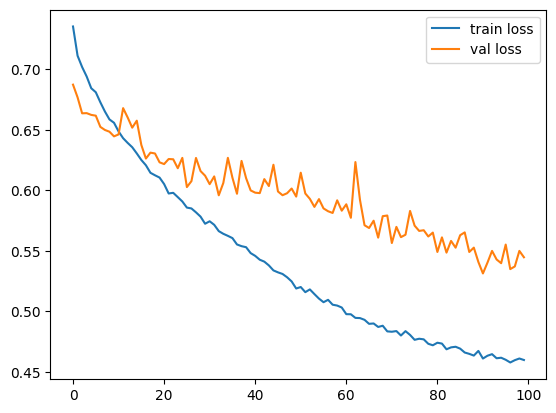

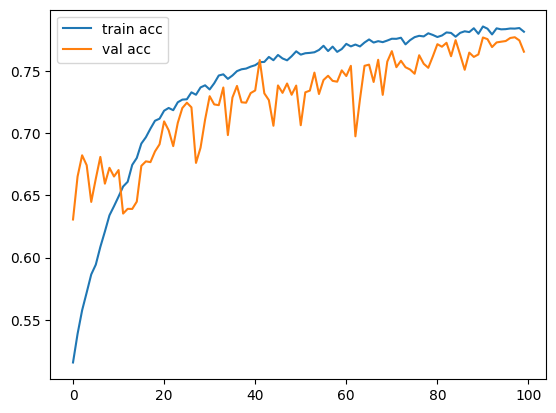

In [13]:
train_loss_history = [] # loss
train_acc_history = [] # accuracy

val_loss_history = [] # loss
val_acc_history = [] # accuracy

from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score

model = GraphSAGE(hparam)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)
model.to(device)
for epoch in range(200):
    total_loss = 0
    train_acc = 0
    train_f1 = 0
    train_precision = 0
    train_recall = 0
    train_auc = 0

    val_loss = 0
    val_acc = 0
    val_f1 = 0
    val_precision = 0
    val_recall = 0
    val_auc = 0

    for batch in train_loader:

        model.train()
        optimizer.zero_grad()
 
        out = model(batch.x.to(device), batch.edge_index.to(device))
        out = nn.functional.log_softmax(out, dim=1)

        preds = out[batch.train_mask].to("cpu")
        y_true  = batch.y[batch.train_mask].to("cpu")

        loss = criterion(preds, y_true)

        preds = out[batch.train_mask].argmax(dim=1).to("cpu")
        train_acc += accuracy_score(y_true, preds)
        train_f1 += f1_score(y_true, preds, average="macro")
        train_precision += precision_score(y_true, preds, average="macro")
        train_recall += recall_score(y_true, preds, average="macro")
        train_auc += roc_auc_score(y_true, preds, average="macro")
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()

    for batch in val_loader:
        model.eval()
        out = model(batch.x.to(device), batch.edge_index.to(device))
        out = nn.functional.log_softmax(out, dim=1)

        preds = out[batch.val_mask].to("cpu")
        y_true  = batch.y[batch.val_mask].to("cpu")

        val_loss += criterion(preds, y_true).item()

        preds = out[batch.val_mask].argmax(dim=1).to("cpu")
        val_acc  += accuracy_score(y_true, preds)
        val_f1   += f1_score(y_true, preds, average="macro")
        val_precision += precision_score(y_true, preds, average="macro")
        val_recall    += recall_score(y_true, preds, average="macro")
        val_auc       += roc_auc_score(y_true, preds, average="macro")
    
    train_acc_history.append(train_acc/len(train_loader))
    train_loss_history.append(total_loss/len(train_loader))

    val_acc_history.append(val_acc/len(val_loader))
    val_loss_history.append(val_loss/len(val_loader))

    # print statistics in each epoch with 3 decimal places
    print(f'Epoch {epoch+1:03d}\nTrain Loss: {total_loss/len(train_loader):.3f} | Train Acc: {train_acc/len(train_loader):.3f} | Train F1: {train_f1/len(train_loader):.3f} | Train Precision: {train_precision/len(train_loader):.3f} | Train Recall: {train_recall/len(train_loader):.3f} | Train AUC: {train_auc/len(train_loader):.3f}')
    print(f'Val Loss: {val_loss/len(val_loader):.3f} | Val Acc: {val_acc/len(val_loader):.3f} | Val F1: {val_f1/len(val_loader):.3f} | Val Precision: {val_precision/len(val_loader):.3f} | Val Recall: {val_recall/len(val_loader):.3f} | Val AUC: {val_auc/len(val_loader):.3f}')

# display loss and accuracy
import matplotlib.pyplot as plt

plt.plot(train_loss_history, label='train loss')
plt.plot(val_loss_history, label='val loss')
plt.legend()
plt.show()

plt.plot(train_acc_history, label='train acc')
plt.plot(val_acc_history, label='val acc')
plt.legend()
plt.show()
